In [188]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from netrep.metrics import LinearMetric, GaussianStochasticMetric

# The parameters I ran the experiment with. 
PROMPT = "A long time ago"
PROMPT_LENGTH = 4
SEEDS = [100, 400, 900]
TEMPERATURES = [1e-10, 1, 2]
NUM_EXPERIMENTS = 800
NUM_TOKENS = 20



np.random.seed(42)


# Of shape (Temperature, Seed, Num_Experiments, Num_Classes, 64)
per_trial_data = np.load('data/2_1M_experiment800N_3_TEMPS_PROMPTA_per_trial_tensor.npy')

# per_trial_data = np.empty((2, 3, NUM_EXPERIMENTS, 23, 64))
# per_trial_data_promptA = np.load('data/2_1M_experiment800N_3_TEMPS_PROMPTA_per_trial_tensor.npy')
# per_trial_data_promptB = np.load('data/2_1M_experiment800N_3_TEMPS_PROMPTB_per_trial_tensor.npy')
# per_trial_data[0] = per_trial_data_promptA[2]
# per_trial_data[1] = per_trial_data_promptB[2]

# per_trial_data = np.concat((per_trial_data, per_trial_data_promptB))

per_trial_data.shape

(3, 3, 800, 23, 64)

In [189]:
# Take the average over the number of experiments. 
mean_trajectories = np.mean(per_trial_data, 2)
print(mean_trajectories.shape)

# Then reshape the trajectories into (Variables, Time points, Neurons)
reshaped = mean_trajectories.reshape(len(TEMPERATURES) * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, 64)
# reshaped = mean_trajectories.reshape(10 * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, 64)

print(reshaped.shape)

# Array of [ (Time points, Neurons), ... ]
Xs = []
for i in range(reshaped.shape[0]):
    # Random 10 Neurons
    # cols = np.random.choice(reshaped.shape[2], size=10, replace=False)
    # Xs.append(np.take(reshaped[i], cols, axis=-1))

    # First 10 Neurons
    Xs.append(reshaped[i, :, :10])

    # All 64 neurons.
    # Xs.append(reshaped[i])


print(len(Xs))
print(Xs[0].shape)

(3, 3, 23, 64)
(9, 23, 64)
9
(23, 10)


In [ ]:

# ### AVERAGE OVER N TRIALS
# mean_test = np.mean(per_trial_data, 2)
# mean_test = mean_test.reshape((6, 23, 64))


# X = []

# for i in range(6):
#     X.append(mean_test[i,:, :])
# #     # Y.append(t2[i, :, -10:])

### AVERAGE OVER THE TOKENS
# mean_test = np.mean(per_trial_data, 3)
# mean_test = mean_test.reshape((6, 800, 64))

# X = []
# for i in range(6):
#     X.append(mean_test[i,:, :])
# #     # Y.append(t2[i, :, -10:])

### AVERAGE OVER THE SEEDS
# mean_test = np.mean(per_trial_data, 1)
# t1 = mean_test[1] # 

# X = []

# for i in range(25):
#     X.append(t1[i, :, :])
#     X.append(t1[i, :, :])
#     # Y.append(t2[i, :, -10:])


# split_data = [np.array_split(x, 2) for x in Xs]
# # print(X[0].shape)
# X_train = [x for (x, _) in split_data ]
# X_test = [x for (_, x) in split_data]

# metric = LinearMetric(alpha=1)
# train_dist, test_dist = metric.pairwise_distances(X_train, X_test)



Parallelizing 15 distance calculations with 8 processes.


Computing distances: 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


In [190]:
### LINEAR PROCRUSTES DISTANCE ###

split_data = [np.array_split(x, 2) for x in Xs]
X_train = [x for (x, _) in split_data ]
X_test = [x for (_, x) in split_data]

# print(Xs[0].shape)
# print(X_train[0].shape)
# print(X_test[0].shape)

alphas = [0, 0.5, 1] # alphas to use for linear metric
linear_distances = [] # array of distances

# print(f"len(Xs)={len(Xs)}")
# print(f"len(X_train)={len(X_train)}")
# print(f"len(X_test)={len(X_test)}")


for alpha in alphas:
    metric = LinearMetric(alpha=alpha, score_method="euclidean")
    # train_dist, test_dist = metric.pairwise_distances(X_train, X_test)  
    test_dist, _ = metric.pairwise_distances(Xs)
    linear_distances.append(test_dist)

print(np.max(linear_distances))

Parallelizing 36 distance calculations with 8 processes.


Computing distances: 100%|██████████| 36/36 [00:01<00:00, 20.56it/s]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:01<00:00, 29.10it/s]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:01<00:00, 29.22it/s]

0.2556397851648678


In [195]:
### CALCULATES STOCHASTIC SHAPE DISTANCE ###
### DONT FIGURE TO REDUCE FEATURES FROM 64 to 10 ### 
import random

gaussian_distances = []

def cov3d(data):
    '''
    Calculates the covariance for a 3D array.
    Iterates over L (some number of parameters or samples) and calculates the covariance.
    '''
    if(len(data.shape) != 3):
        print("ERROR NOT 3D")
        return None

    L, N, M = data.shape
    covar_matrices = np.zeros((L, M, M))
    for i in range(L):
        covar_matrices[i] = np.cov(data[i, :, :], rowvar=False)
    
    return covar_matrices


#--------------------------------------------------------------------------------------------------------------------------------------------
N_COMPONENTS = 10
# First do PCA bc covariance on 64 features takes a long time
# TODO: TEMPORARILY NOT DOING THIS BECAUSE I'M NOT SURE I AM DOING PCA CORRECTLY
# reshaped_per_trial_data = per_trial_data.reshape(((len(TEMPERATURES)* len(SEEDS), NUM_EXPERIMENTS, PROMPT_LENGTH + NUM_TOKENS - 1, 64) ))
# pca_per_trial_data = np.empty((len(TEMPERATURES)*len(SEEDS), NUM_EXPERIMENTS, PROMPT_LENGTH + NUM_TOKENS - 1, N_COMPONENTS))
# print(pca_per_trial_data.shape)

# pca = PCA(n_components=N_COMPONENTS)
# for i in range(reshaped_per_trial_data.shape[0]):
#     for n in range(NUM_EXPERIMENTS):
#         pca.fit(reshaped_per_trial_data[i, n])
#         pca_data = pca.transform(reshaped_per_trial_data[i,n])
#         pca_per_trial_data[i, n] = pca_data

#--------------------------------------------------------------------------------------------------------------------------------------------

# Get the mean trajectories
reshaped = per_trial_data.reshape((len(TEMPERATURES) * len(SEEDS), 
                                NUM_EXPERIMENTS, PROMPT_LENGTH + NUM_TOKENS - 1, 64))
per_trial_data_random_neurons_selected = np.empty((len(TEMPERATURES) * len(SEEDS), 
                                NUM_EXPERIMENTS, PROMPT_LENGTH + NUM_TOKENS - 1,10))
for i in range(reshaped.shape[0]):
    # RANDOM 10
    # cols = np.random.choice(reshaped.shape[3], size=10, replace=False)
    # Have to use np.take because it preserves the order of the axes. Otherwise, it reverses the order.
    # per_trial_data_random_neurons_selected[i, :,: ,:] = np.take(reshaped[i], cols, axis=-1)

    # FIRST 10
    per_trial_data_random_neurons_selected[i, :,: ,:] = reshaped[i, :, :, :10]


# Get mean over the experiments. 
pca_mean_trajectory = np.mean(per_trial_data_random_neurons_selected, 1)
print(pca_mean_trajectory.shape)

# Get covariance over N experiemnts and create input array
covars = []
means = []
# # input to metric is (23, 10) and cov needs to be (23, 10, 10)
reshaped_for_covariance = per_trial_data_random_neurons_selected.reshape( (per_trial_data_random_neurons_selected.shape[0], 
                per_trial_data_random_neurons_selected.shape[2], per_trial_data_random_neurons_selected.shape[1], 
                per_trial_data_random_neurons_selected.shape[3]))

for i in range(reshaped_for_covariance.shape[0]):
    covar = cov3d(reshaped_for_covariance[i])
    covars.append(covar)
    means.append(pca_mean_trajectory[i])



# Use this split as suggested by the netrep documentation. 
split_covars = [np.array_split(x, 2) for x in covars]
covar_train = [x for (x, _) in split_covars ]
covar_test = [x for (_, x) in split_covars]

split_means = [np.array_split(x, 2) for x in means]
mean_train = [x for (x, _) in split_means ]
mean_test = [x for (_, x) in split_means]

X_train = []
X_test = []

for i in range(len(mean_train)):
    X_train.append((mean_train[i], covar_train[i]))
    X_test.append((mean_test[i], covar_test[i]))

alphas = [0, 1, 2] # 0 only uses covar, 1 = 2-Wasserstein, 2 = only uses means
for alpha in alphas:
    metric = GaussianStochasticMetric(alpha=alpha, init='rand', n_restarts=50)
    train_dist, test_dist = metric.pairwise_distances(X_train, X_test)
    gaussian_distances.append(test_dist)


(9, 23, 10)
Parallelizing 36 distance calculations with 8 processes.


Computing distances: 100%|██████████| 36/36 [02:38<00:00,  4.40s/it]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:36<00:00,  1.02s/it]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:01<00:00, 20.27it/s]


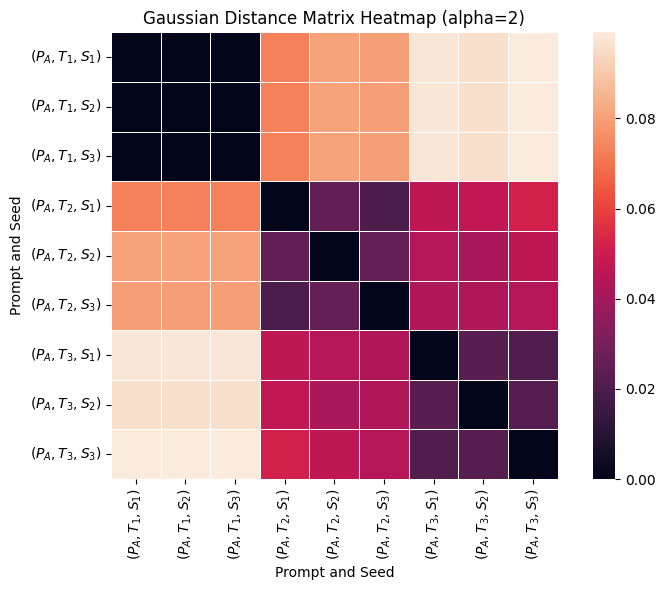

In [ ]:

# font = {'size': 10}
# plt.rc('font', **font)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed

n_T, n_S = per_trial_data.shape[:2]

labels = [rf"$(P_A, T_{{{t+1}}}, S_{{{s+1}}})$" for t in range(n_T) for s in range(n_S)]
# labels = [rf"$(P_{{{t+1}}}, T_{1}, S_{{{s+1}}})$" for t in range(2) for s in range(n_S)]

# labels_2 = [rf"$(P_B, T_{{{t+1}}}, S_{{{s+1}}})$" for t in range(5) for s in range(n_S)]

sns.heatmap(linear_distances[2], 
            xticklabels=labels,
            yticklabels=labels,
            square=True,
            annot=False, 
            fmt=".2f", 
            linewidths=.5)


plt.title('Linear Distance Matrix Heatmap (alpha=0)')
plt.xlabel("Prompt and Seed")
plt.ylabel("Prompt and Seed")


plt.tight_layout()
plt.show()